# Lesson 2 First Data Example (Classic perspective + Greedy ML)

We have seen a top view of Titanic competition, without taking much care to the code. We also know the basics of tabular data and classification problem. 

Now we are going to take a deeper look at data visualization and classical data analysis + statistics. After that, we will apply the `sklearn` versions of the basic ML algorithms that we have seen. 

### Some questions

* Is titanic easy? 
* Is $77\%$ the best possible accuracy? 
* Can we apply better models? 
* Is the public leaderboard a good benchmark?
https://www.kaggle.com/c/titanic/discussion/57447 (is this the real trick? maybe no?)

## Step by step analysis

### Load libraries and download data

In [1]:
import os
import pandas as pd
import numpy as np

t_data_path = f"{os.getcwd()}/data/titanic"
print(t_data_path)

/home/josem/Escritorio/curs_python/dapy_v2/lessons/lesson2/data/titanic


In [2]:
!kaggle competitions download -c titanic -p {t_data_path} #--force

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# import os
# os.chdir(f"{os.getcwd()}/..")
# from ml_aid import *

# os.chdir(f"{t_data_path}/../..")

### Read data and pre-visualize

In [4]:
data = {}
data["train"] = pd.read_csv(f"{t_data_path}/train.csv")
data["test"] = pd.read_csv(f"{t_data_path}/test.csv")

In [5]:
data["train"].head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [6]:
data["test"].head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

Which kinds of variables do we have:
* **Categorical**
    - Ordinal: Pclass
    - Boolean: Sex
    - Non ordered: Cabin, Embarked 
* **Numerical**
    - Discrete: PassengerId, SibSp, Parch, Survived
    - Continuous: Age, Fare
* **Text**
    - Ticket, Name
    
Before going onto analysis of text data, we need to convert Categorical data to something that we can analyze, and we will see a general plot.

### Join the data
First of all, we need to join both datasets so when we convert our features to categories, they will be converted in the same way in train set than in test set

In [7]:
data["train"]["is_train"] = True
data["test"]["is_train"] = False

In [8]:
data["all"] = pd.concat([data["train"],data["test"]],axis=0)

/home/josem/my_envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [9]:
data["all"].head()

Age Cabin Embarked     Fare  \
0  22.0   NaN        S   7.2500   
1  38.0   C85        C  71.2833   
2  26.0   NaN        S   7.9250   
3  35.0  C123        S  53.1000   
4  35.0   NaN        S   8.0500   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                             Heikkinen, Miss. Laina      0            3   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                           Allen, Mr. William Henry      0            5   

   Pclass     Sex  SibSp  Survived            Ticket  is_train  
0       3    male      1       0.0         A/5 21171      True  
1       1  female      1       1.0          PC 17599      True  
2       3  female      0       1.0  STON/O2. 3101282      True  
3       1  female      1       1.0            113803      True  
4       3    male      0       0.0            373450      True

**Pclass** is of type `int64` which is ok as we want Pclass to be ordered.

In [10]:
## Pclass
data["all"]["Pclass"].head()

0    3
1    1
2    3
3    1
4    3
Name: Pclass, dtype: int64

**Sex** is of type `object` which here means string, and we need to convert this data to categories.

In [11]:
## Sex
data["all"]["Sex"].head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [12]:
data["all"]["Sex"] = data["all"]["Sex"].astype("category")

**Cabin** is between categorical and text, we are going to treat it as categorical variable. Remember that there is a category for NaN.

In [13]:
## Cabin
data["all"]["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [14]:
data["all"]["Cabin"] = data["all"]["Cabin"].astype("category")

In [15]:
data["all"]["Cabin"].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: category
Categories (186, object): [A10, A11, A14, A16, ..., F38, F4, G6, T]

In [16]:
## Embarked
data["all"]["Embarked"] = data["all"]["Embarked"].astype("category")

In [17]:
data["all"].dtypes

Age             float64
Cabin          category
Embarked       category
Fare            float64
Name             object
Parch             int64
PassengerId       int64
Pclass            int64
Sex            category
SibSp             int64
Survived        float64
Ticket           object
is_train           bool
dtype: object

By now everything is looking good, so we are going to see now a general plot of the data with some statistics.

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
data_2_plot = data["all"][data["all"]["is_train"] == True].copy()

In [20]:
from pandas_summary import DataFrameSummary

In [21]:
ds_plot = DataFrameSummary(data_2_plot)

In [22]:
ds_plot.columns_stats

Age        Cabin     Embarked     Fare    Name    Parch  \
counts            714          204          889      891     891      891   
uniques            88          147            3      248     891        7   
missing           177          687            2        0       0        0   
missing_perc   19.87%       77.10%        0.22%       0%      0%       0%   
types         numeric  categorical  categorical  numeric  unique  numeric   

             PassengerId   Pclass   Sex    SibSp Survived       Ticket  \
counts               891      891   891      891      891          891   
uniques              891        3     2        7        2          681   
missing                0        0     0        0        0            0   
missing_perc          0%       0%    0%       0%       0%           0%   
types            numeric  numeric  bool  numeric     bool  categorical   

              is_train  
counts             891  
uniques              1  
missing              0  
missing_perc        0%  
types         constant

/home/josem/my_envs/fastai/lib/python3.6/site-packages/pandas_summary/__init__.py:134: RuntimeWarning: invalid value encountered in minimum
  series, series.mean() + multiplier * series.std())
/home/josem/my_envs/fastai/lib/python3.6/site-packages/pandas_summary/__init__.py:148: RuntimeWarning: invalid value encountered in minimum
  series, series.median() + multiplier * series.mad())


mean                         29.6991
std                          14.5265
variance                     211.019
min                             0.42
max                               80
5%                                 4
25%                           20.125
50%                               28
75%                               38
95%                               56
iqr                           17.875
kurtosis                    0.178274
skewness                    0.389108
sum                          21205.2
mad                          11.3229
cv                          0.489122
zeros_num                          0
zeros_perc                        0%
deviating_of_mean                179
deviating_of_mean_perc        20.09%
deviating_of_median              196
deviating_of_median_perc      22.00%
top_correlations                    
counts                           714
uniques                           88
missing                          177
missing_perc                  19.87%
t

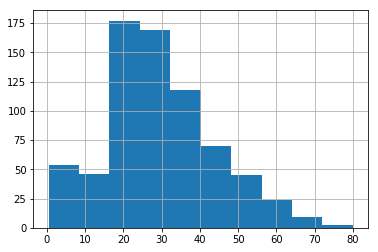

In [23]:
ds_plot["Age"]

Text(0.5, 0, 'Age')

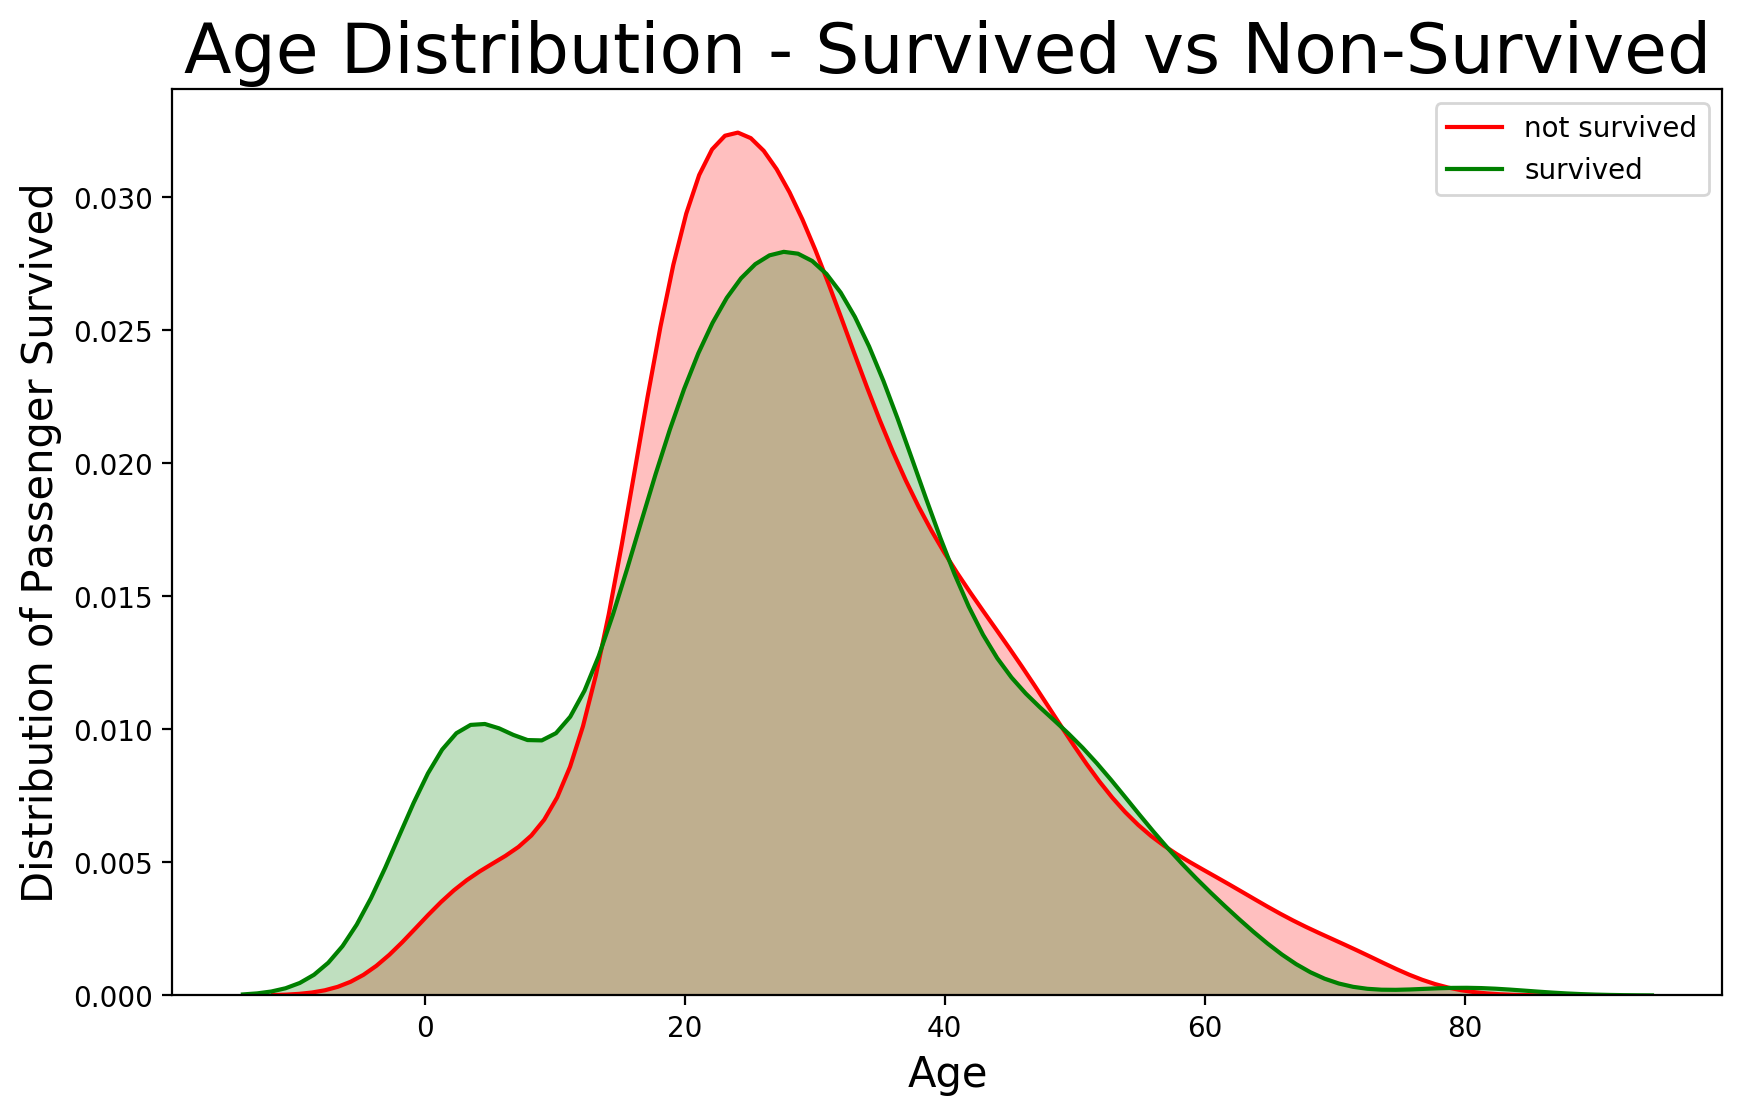

In [24]:
fig = plt.figure(figsize=(10,6),dpi=200)
ax=sns.kdeplot(data_2_plot[data_2_plot["Survived"] == 0]["Age"].dropna() , 
               color="r",
               shade=True,
               label="not survived")
ax=sns.kdeplot(data_2_plot[data_2_plot["Survived"] == 1]["Age"].dropna() , 
               color="g",
               shade=True, 
               label="survived")
plt.title("Age Distribution - Survived vs Non-Survived", fontsize = 25)
plt.ylabel("Distribution of Passenger Survived", fontsize = 15)
plt.xlabel("Age", fontsize = 15)

Here we can see that babys and kids tend to survive. Thus, **Age** seems a good feature at least to distinguish in a small part of the dataset.

In [25]:
fig = plt.figure(figsize=(10,6),dpi=200)
ax=sns.kdeplot(data_2_plot[data_2_plot["Survived"] == 0]["Embarked"].cat.codes.dropna() , 
               color="r",
               shade=True,
               label="not survived")
ax=sns.kdeplot(data_2_plot[data_2_plot["Survived"] == 1]["Embarked"].cat.codes.dropna() , 
               color="g",
               shade=True, 
               label="survived")
plt.title("Embarked Distribution - Survived vs Non-Survived", fontsize = 25)
plt.ylabel("Distribution of Passenger Survived", fontsize = 15)
plt.xlabel("Embarked", fontsize = 15)
labels = ["C", "Q", "S"]
plt.xticks(sorted(data_2_plot["Embarked"].cat.codes.unique()+1), labels);

The differences between the distributions in `C` and `Q` are shallow, but in `S` seems important. Is wierd that Embarked variable has predictive power, so we can try to relate this variable with others to see if is about Embarked, or is about other variables.

In [26]:
data_2_plot["Embarked_codes"] = data_2_plot["Embarked"].cat.codes

In [27]:
sns.heatmap(data_2_plot.dropna().corr());

So as we can see, it seems that Embarked can be related with Pclass, and Pclass can be informative maybe because is related to access to liveboats or something else.

In [28]:
sns.pairplot(data_2_plot[["Embarked_codes","Pclass","Survived"]].dropna(),
             x_vars=["Embarked_codes","Pclass"],
             y_vars=["Embarked_codes","Pclass"],
             hue="Survived",diag_kind="hist");

What about `Pclass`? It will be a nice feature?

Text(0.5, 0, 'Pclass')

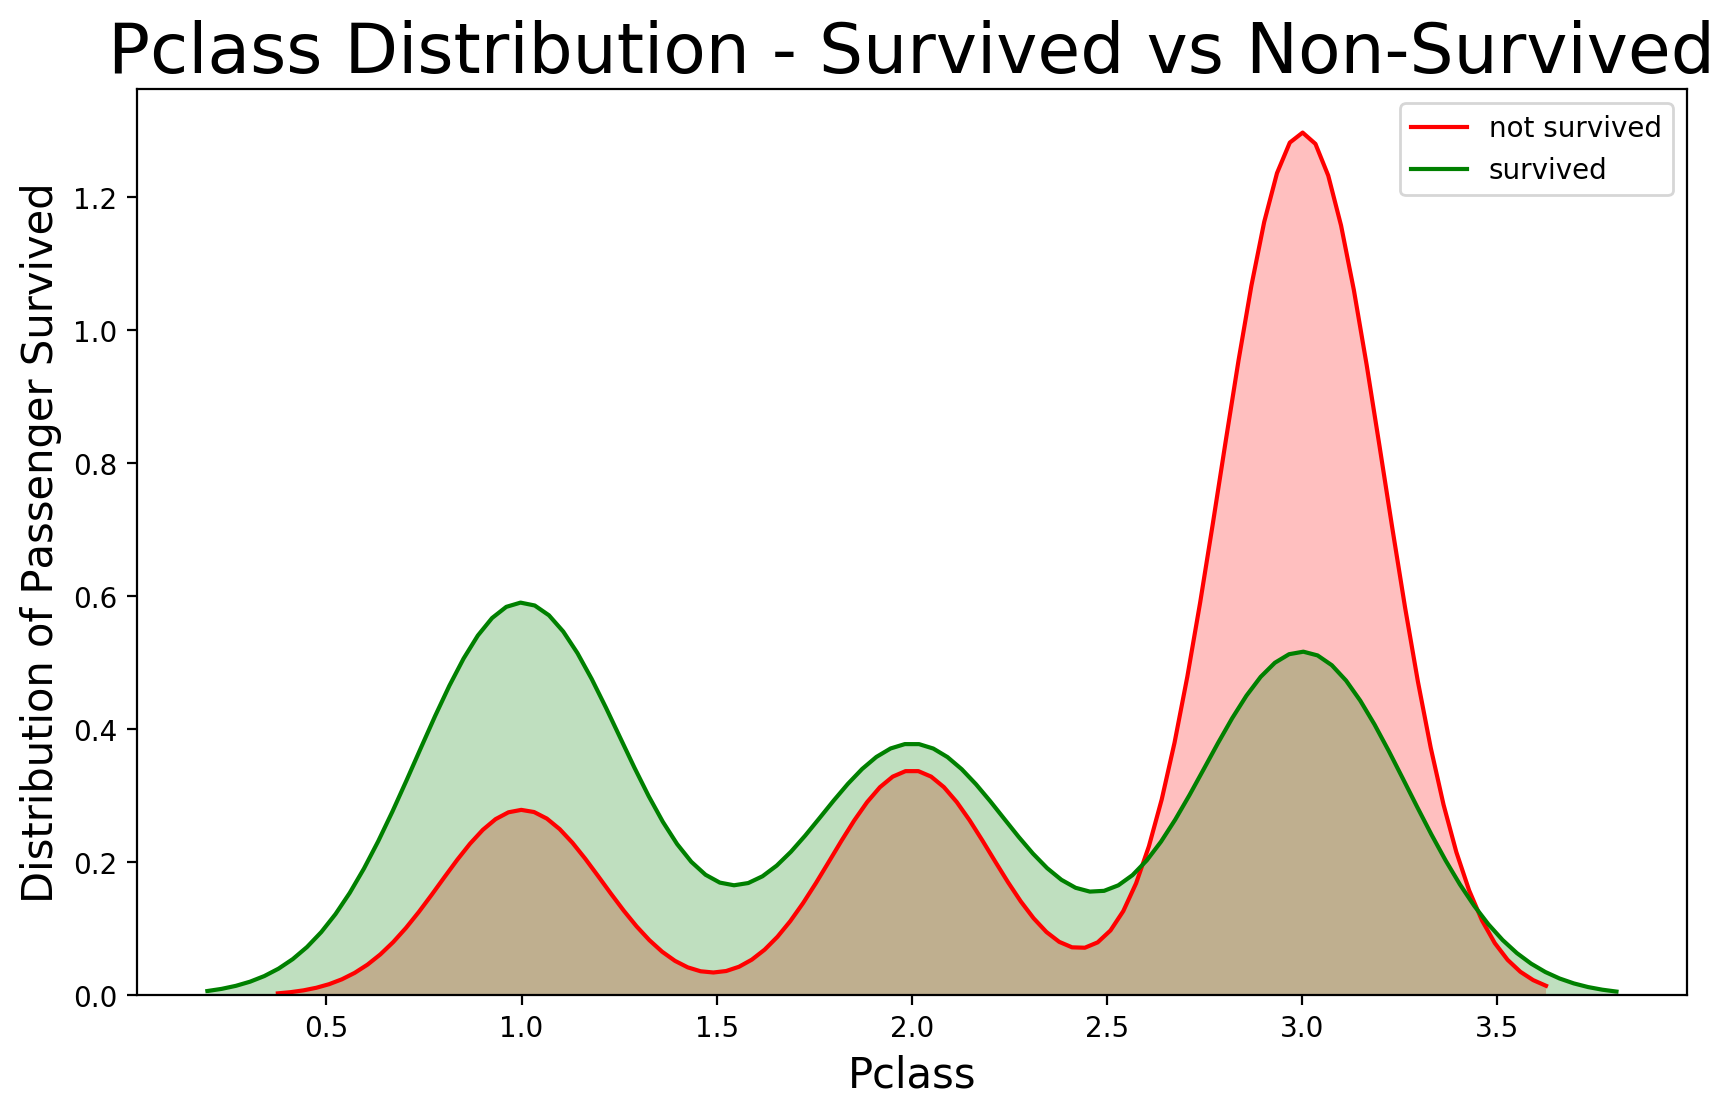

In [29]:
fig = plt.figure(figsize=(10,6),dpi=200)
ax=sns.kdeplot(data_2_plot[data_2_plot["Survived"] == 0]["Pclass"].dropna() , 
               color="r",
               shade=True,
               label="not survived")
ax=sns.kdeplot(data_2_plot[data_2_plot["Survived"] == 1]["Pclass"].dropna() , 
               color="g",
               shade=True, 
               label="survived")
plt.title("Pclass Distribution - Survived vs Non-Survived", fontsize = 25)
plt.ylabel("Distribution of Passenger Survived", fontsize = 15)
plt.xlabel("Pclass", fontsize = 15)

We can also take a look at `Sex` variable.

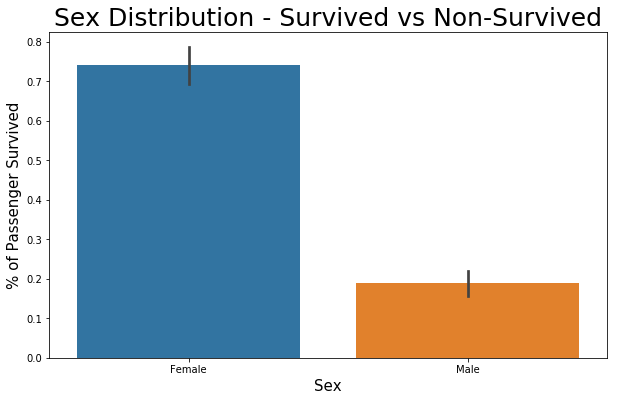

In [30]:
plt.subplots(figsize = (10,6))
sns.barplot(x = "Sex", 
            y = "Survived", 
            data=data_2_plot, 
            linewidth=2)
plt.title("Sex Distribution - Survived vs Non-Survived", fontsize = 25)
plt.xlabel("Sex", fontsize = 15);
plt.ylabel("% of Passenger Survived", fontsize = 15);
labels = ["Female", "Male"]
val = sorted(data_2_plot["Sex"].cat.codes.unique())
plt.xticks(val, labels);

This feature seems to be the most informative, as just taking this into account would led us to a $75\%$ acc. For what we are seeing, `Sex` would be the best variable to split at the first node of a DT.

<span style="color:blue">**In-class**: Keep analyzing the remaining variables, to see if we can find something useful.</span>

### Feature engineering
Now we are going to create new features from the ones that we have. This is to help our ML models to understand even more relations within the data.

#### Text variables

In [31]:
data["all"]["name_length"] = data["all"]["Name"].apply(lambda x: len(x))

In [32]:
data["all"]["title"] = data["all"]["Name"].apply(lambda x: x.split(".")[0].split(",")[1])

In [33]:
def group_f(title):
    rares_list = ["Dr","Col","Major","Don",
                  "Jonkheer","Sir","Lady","Capt",
                  "the Countless","Rev"]

    if title == "Ms" or title == "Mlle":
        return "Miss"
    elif title == "Mme":
        return "Mrs"
    elif any(title in s for s in rares_list):
        return "rare"
    else:
        return title

data["all"]["title"] = data["all"]["title"].apply(lambda x: group_f(x))

In [34]:
data["all"].head()

Age Cabin Embarked     Fare  \
0  22.0   NaN        S   7.2500   
1  38.0   C85        C  71.2833   
2  26.0   NaN        S   7.9250   
3  35.0  C123        S  53.1000   
4  35.0   NaN        S   8.0500   

                                                Name  Parch  PassengerId  \
0                            Braund, Mr. Owen Harris      0            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...      0            2   
2                             Heikkinen, Miss. Laina      0            3   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)      0            4   
4                           Allen, Mr. William Henry      0            5   

   Pclass     Sex  SibSp  Survived            Ticket  is_train  name_length  \
0       3    male      1       0.0         A/5 21171      True           23   
1       1  female      1       1.0          PC 17599      True           51   
2       3  female      0       1.0  STON/O2. 3101282      True           22   
3       1  female      1       1.0            113803      True           44   
4       3    male      0       0.0            373450      True           24   

   title  
0     Mr  
1    Mrs  
2   Miss  
3    Mrs  
4     Mr

#### Others

In [35]:
data["all"]["family_size"] = data["all"]["SibSp"] + data["all"]["Parch"] + 1

In [36]:
data["all"]["family_group"] = data["all"]["family_size"].apply(
    lambda x: "alone" if x <=1 else "small" if x <= 4 else "large")
data["all"]["family_group"] = data["all"]["family_group"].astype("category")

In [37]:
data["all"]["weighted_fare"] = data["all"]["Fare"]/data["all"]["family_size"]

In [38]:
passengers = data["test"]["PassengerId"].values
data["all"].drop("PassengerId", axis=1, inplace=True)
data["all"].drop("Ticket", axis=1, inplace=True)
data["all"].drop("Cabin", axis=1, inplace=True)

In [39]:
data["all"].drop("Name", axis=1, inplace=True)

Now we need to convert feature `title` to category and all those categorical features to their numbers.

In [40]:
data["all"]["title"] = data["all"]["title"].astype("category") 

In [41]:
data["all"].dtypes

Age               float64
Embarked         category
Fare              float64
Parch               int64
Pclass              int64
Sex              category
SibSp               int64
Survived          float64
is_train             bool
name_length         int64
title            category
family_size         int64
family_group     category
weighted_fare     float64
dtype: object

In [42]:
data["all"]["Embarked"] = data["all"]["Embarked"].cat.codes
data["all"]["Sex"] = data["all"]["Sex"].cat.codes
data["all"]["title"] = data["all"]["title"].cat.codes
data["all"]["family_group"] = data["all"]["family_group"].cat.codes

In [43]:
data["all"]["Age"] = data["all"]["Age"].fillna(data["all"]["Age"].mean())

In [44]:
data["train"] = data["all"][data["all"]["is_train"] == True].copy()

In [45]:
data["test"] = data["all"][data["all"]["is_train"] == False].copy()

In [46]:
data["train"].drop("is_train", axis=1, inplace=True)
data["test"].drop("is_train", axis=1, inplace=True)

In [47]:
data["train"].head()

Age  Embarked     Fare  Parch  Pclass  Sex  SibSp  Survived  name_length  \
0  22.0         2   7.2500      0       3    1      1       0.0           23   
1  38.0         0  71.2833      0       1    0      1       1.0           51   
2  26.0         2   7.9250      0       3    0      0       1.0           22   
3  35.0         2  53.1000      0       1    0      1       1.0           44   
4  35.0         2   8.0500      0       3    1      0       0.0           24   

   title  family_size  family_group  weighted_fare  
0     12            2             2        3.62500  
1     13            2             2       35.64165  
2      9            1             0        7.92500  
3     13            2             2       26.55000  
4     12            1             0        8.05000

Why I'm not replacing the `NaN` values? Well `NaN` is a category itself, is another way to treat the `NaN` values. (not in Age column)

### Splitting the data

Now we need a validation set and cast everything to `np.arrays` to fill the models.

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
X_train, X_val, y_train, y_val = train_test_split(data["train"].drop("Survived",axis=1), 
                                                    data["train"]["Survived"], 
                                                    test_size=0.30, 
                                                    random_state=2)

In [50]:
X_test = data["test"]

### Greedy ML

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [52]:
%%time 
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train,y_train),lr.score(X_val,y_val))

0.43931426327286516 0.34503813314478593
CPU times: user 4.72 ms, sys: 367 µs, total: 5.09 ms
Wall time: 4.34 ms


Linear Regression performs even worse than tossing a coin so the model gets discarded automatically.

In [53]:
%%time 
lr = KNeighborsClassifier(n_neighbors=5)
lr.fit(X_train, y_train)
print(lr.score(X_train,y_train),lr.score(X_val,y_val))

0.8138041733547352 0.7164179104477612
CPU times: user 56.7 ms, sys: 0 ns, total: 56.7 ms
Wall time: 55.2 ms


KNN performs good but is making some overfit, lets see if we can change that.

In [54]:
%%time 
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train, y_train)
print(knn.score(X_train,y_train),knn.score(X_val,y_val))

0.7560192616372392 0.75
CPU times: user 61.6 ms, sys: 0 ns, total: 61.6 ms
Wall time: 60.1 ms


In [55]:
%%time 
dt = DecisionTreeClassifier(max_depth=None)
dt.fit(X_train, y_train)
print(dt.score(X_train,y_train),dt.score(X_val,y_val))

0.9983948635634029 0.7723880597014925
CPU times: user 10.3 ms, sys: 0 ns, total: 10.3 ms
Wall time: 9.31 ms


With DT this is getting better results but, we can reduce also the overfitting of the tree to increase our validation results.

In [56]:
%%time 
dt = DecisionTreeClassifier(max_depth=4,random_state=2)
dt.fit(X_train, y_train)
print(dt.score(X_train,y_train),dt.score(X_val,y_val))

0.8587479935794543 0.8097014925373134
CPU times: user 4.9 ms, sys: 2.44 ms, total: 7.34 ms
Wall time: 7.99 ms


In [57]:
X_test.drop("Survived",axis=1).isnull().sum()

Age              0
Embarked         0
Fare             1
Parch            0
Pclass           0
Sex              0
SibSp            0
name_length      0
title            0
family_size      0
family_group     0
weighted_fare    1
dtype: int64

Minor changes and prepare the submission.

In [58]:
X_test = X_test.drop("Survived",axis=1)
X_test["Fare"] = X_test["Fare"].fillna(X_test["Fare"].mean())
X_test["weighted_fare"] = X_test["weighted_fare"].fillna(X_test["weighted_fare"].mean())

In [60]:
submission = pd.DataFrame([passengers.astype(int),dt.predict(X_test).astype(int)])

In [61]:
submission = submission.T
submission.columns = ["PassengerId","Survived"]

In [63]:
submission.to_csv("data/titanic_submission.csv", index=False)

### Conclusions

There are mainly two different schools that win kaggle competitions (both):
* Who has a deep knowledge about the topic, studies the data in many ways and builds thousands of features
* Who let the machine do the work

My advice is, first let the ML/DL algorithms work, if they do not, you can start diggin into the topic.